# Xray analyzer

## Import and checks

In [1]:
# Import env libraries
import torch
from torchvision import datasets, transforms
import os
import sys

# Local libraries
sys.path.append(os.path.dirname(os.getcwd()))
from src import model_def as md
from src import data_processing as dp
from src import model_eval as me

In [ ]:
# check if Pytorch CUDA is installed correctly

print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("CUDA Device Name:", torch.cuda.get_device_name(0))

print("CUDA Version:", torch.version.cuda)
print("cuDNN Version:", torch.backends.cudnn.version())

## Sorting

### Pre-sorting
Take a test/train sampleset and put it into the respective folder, according to wanted Ns and the split between test and train.

In [ ]:
dp.sort_images_train_test(N=10000, delete_test_train_folder=False)

### Label Sorting

Sort data accoridng to provided label of the given classification of the dataset (data_entry_2017.csv). This is needed for training single outcome models

In [4]:
csv_path = os.path.join("..", "data", "classification", "Data_Entry_2017_v2020.csv")
image_folder = os.path.join("..", "data", "images_train")
output_folder = os.path.join("..", "data", "images_sorted_train")

# dp.organize_images_by_label_folder(csv_path, image_folder, output_folder)

image_folder = os.path.join("..", "data", "images_test")
output_folder = os.path.join("..", "data", "images_sorted_test")

# dp.organize_images_by_label_folder(csv_path, image_folder, output_folder)

#### Data loading

Import a testset to be used in training

We normalize the input since we work in grayscale. No size transformations are done since the dataset is already in 1024X1024.

This is only needed for the single outcome models.

TODO: figure out if we need normalizing in the multi-model

In [5]:

train_image_folder = os.path.join("..", "data", "images_sorted_train")
test_image_folder = os.path.join("..", "data", "images_sorted_test")
# print(train_image_folder)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    transforms.Grayscale(num_output_channels=1), 
])


# dataset_xrays_train = datasets.ImageFolder(root=train_image_folder, transform=transform)
# dataset_xrays_test = datasets.ImageFolder(root=test_image_folder, transform=transform)

# print(dataset_xrays_train)

#### Model setup
Below the actual model is trained

In [6]:
model, data_loader, criterion, optimizer, device = md.setup_model_and_training(None, model_type="MultiAttention", batch_size=16, model_mode="multi", learning_rate=0.00001)
# data_loader_test = md.XrayMultiLabelDataset(os.path.join("data", "images_test"))
# model = md.train_model(model, data_loader, criterion, optimizer, device, num_epochs=5)
data_loader_test = md.setup_dataloader(None, path_multi=os.path.join("..", "data", "images_test"), model_type="MultiAttention") # dataset_xrays_test
model = md.train_multilabel_model(model, data_loader, criterion, optimizer, device, num_epochs=10, data_loader_test=data_loader_test, basename="CNNMultiAttent10krot5")


Number of classes: 15
Classes: shape: (15,)
Series: 'Finding Labels' [str]
[
	"Cardiomegaly"
	"Fibrosis"
	"No Finding"
	"Atelectasis"
	"Effusion"
	…
	"Pneumonia"
	"Mass"
	"Hernia"
	"Consolidation"
	"Infiltration"
]
Using device: cuda
Data loader length: 438
Epoch 1/10, Loss: 23.5289
Data loader length: 438
Epoch 2/10, Loss: 20.3026
Data loader length: 438
Epoch 3/10, Loss: 20.2385
Data loader length: 438
Epoch 4/10, Loss: 20.1333
Data loader length: 438
Epoch 5/10, Loss: 19.9850
Data loader length: 438
Epoch 6/10, Loss: 19.7401
Data loader length: 438
Epoch 7/10, Loss: 19.4221
Data loader length: 438
Epoch 8/10, Loss: 19.1076
Data loader length: 438
Epoch 9/10, Loss: 18.8678
Data loader length: 438
Epoch 10/10, Loss: 18.6617


#### Evaluate the model
First eval against the train set, then evala gainst test set

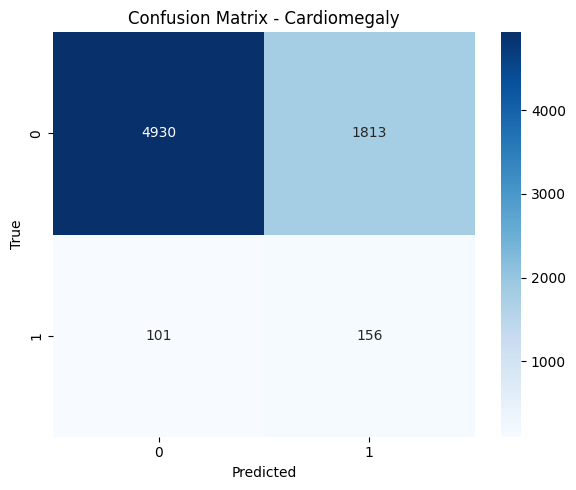

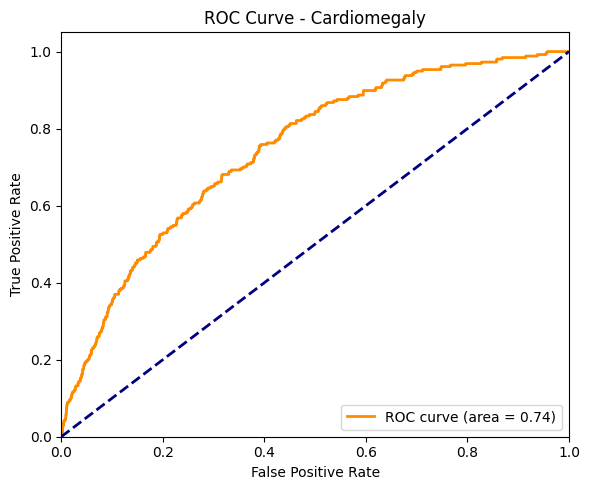

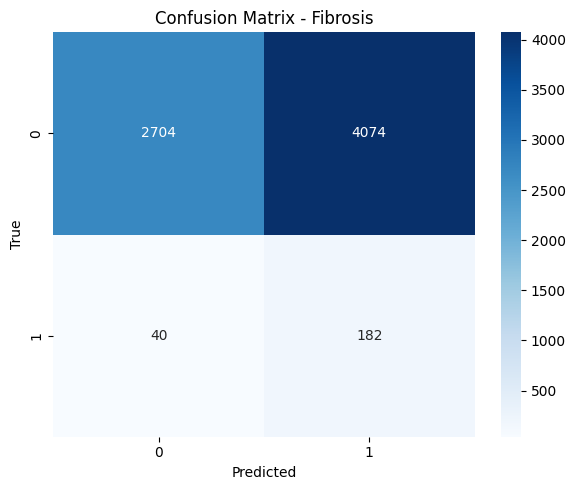

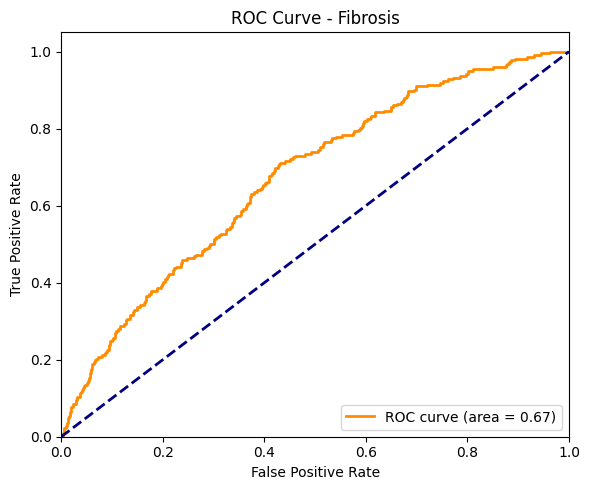

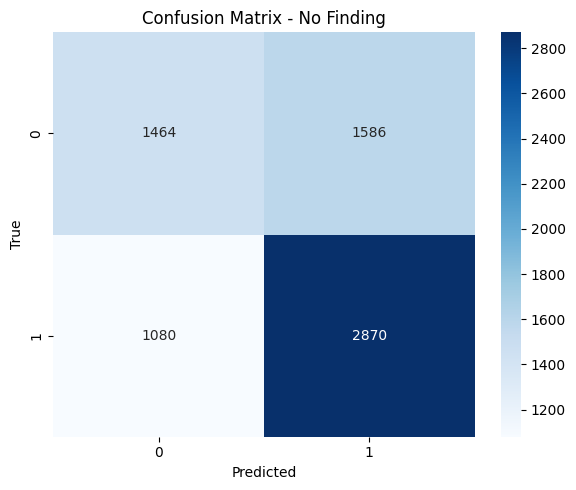

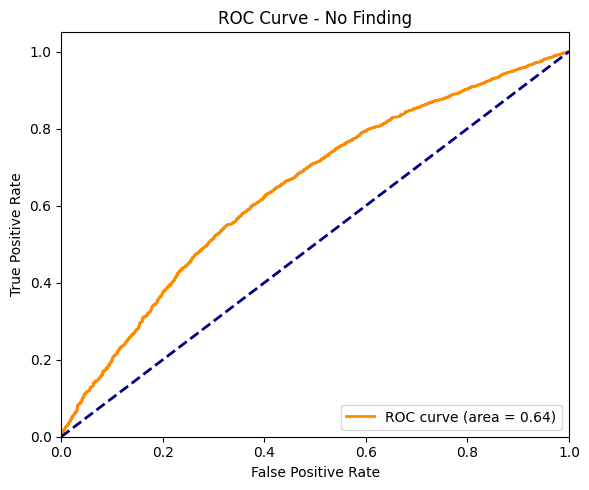

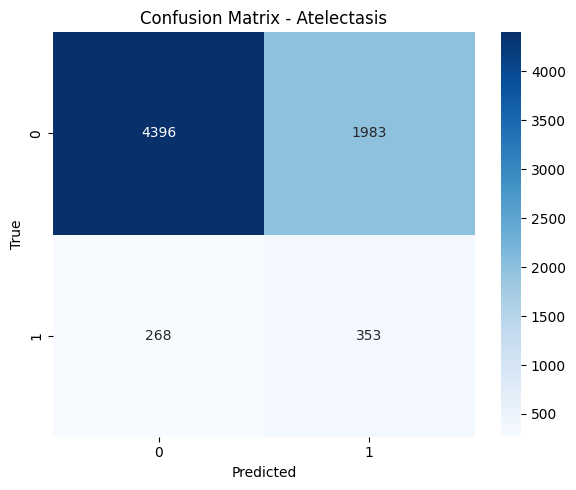

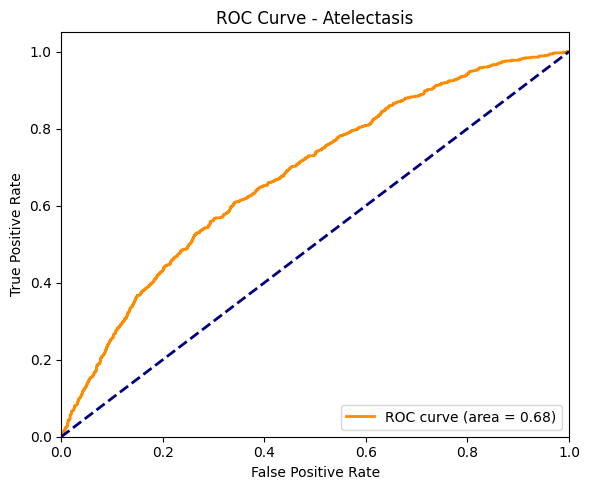

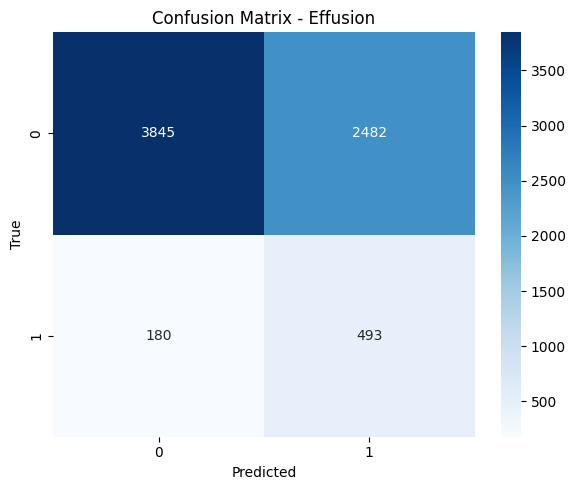

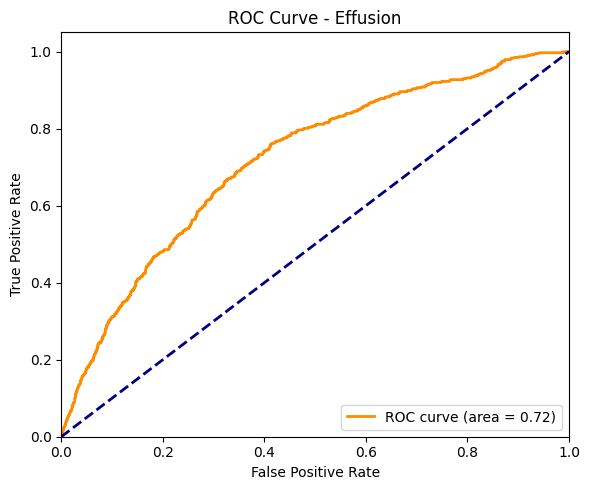

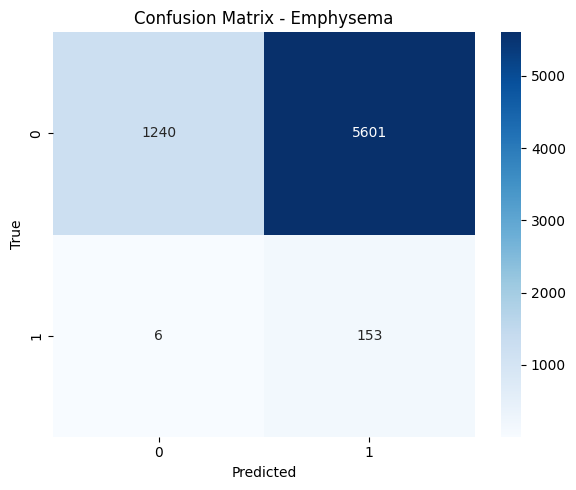

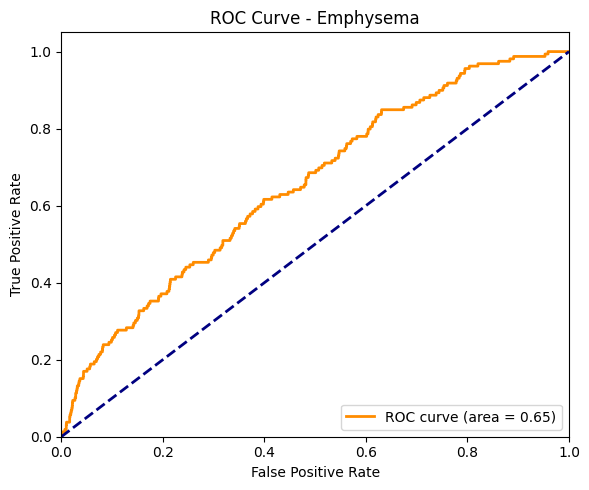

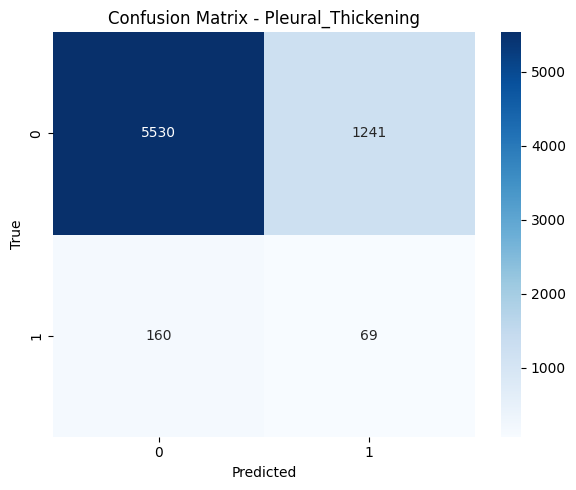

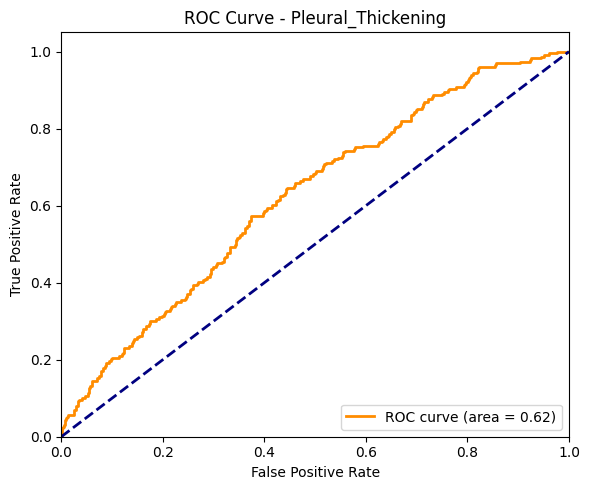

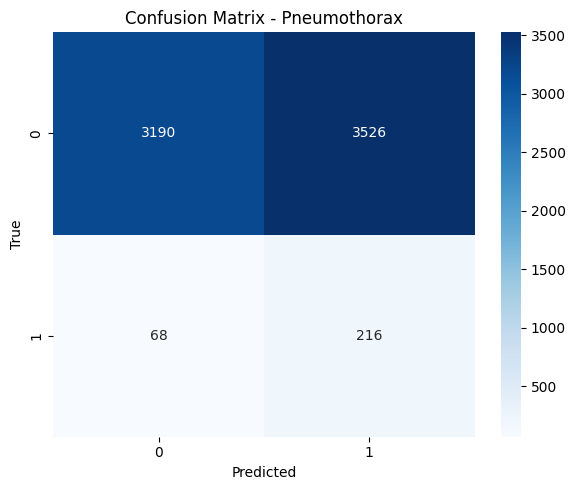

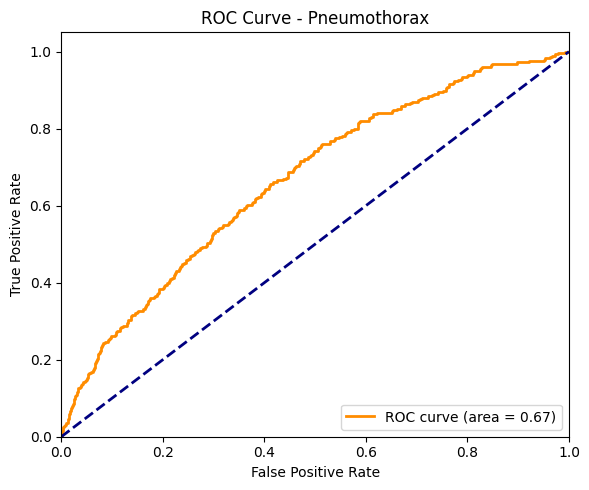

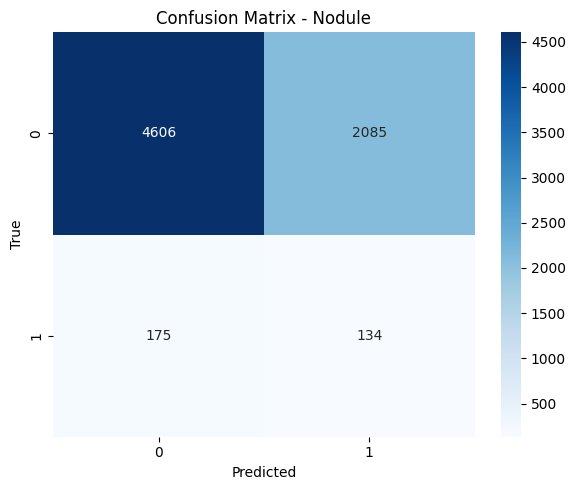

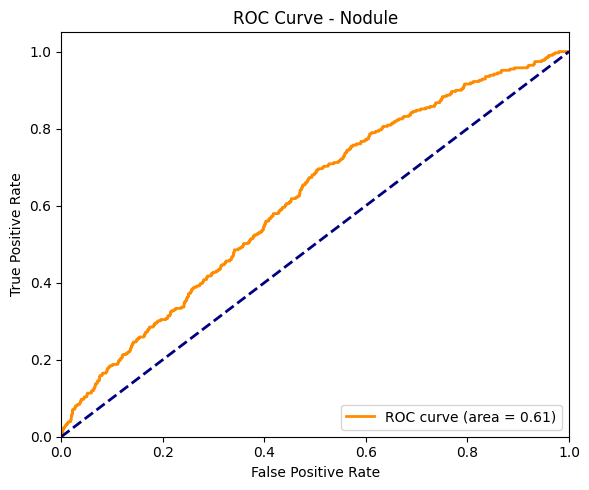

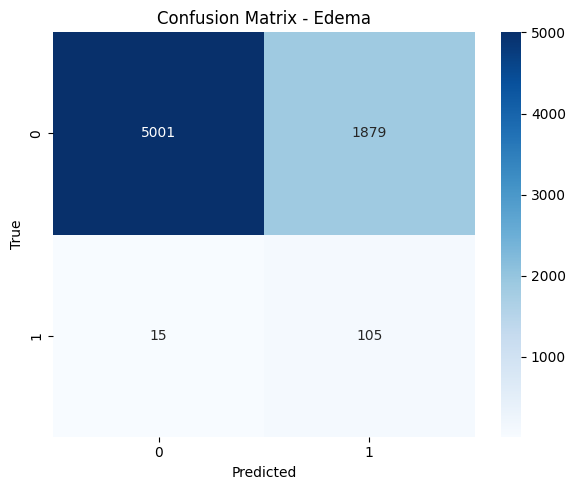

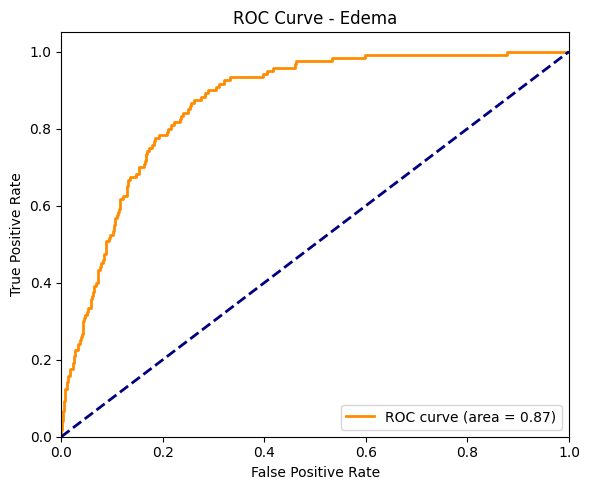

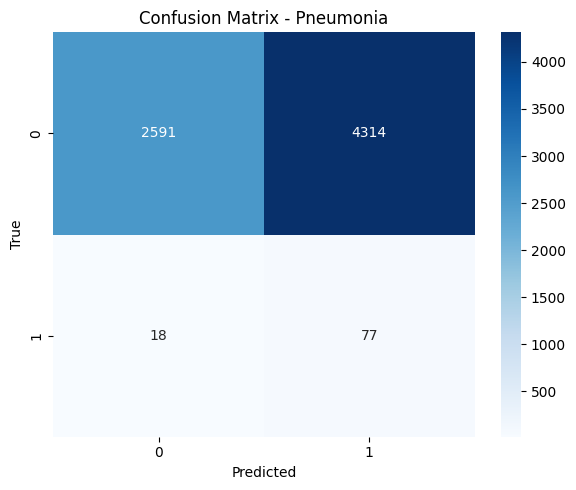

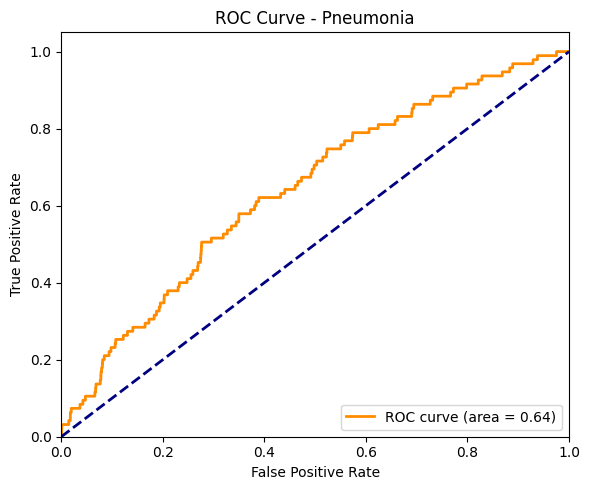

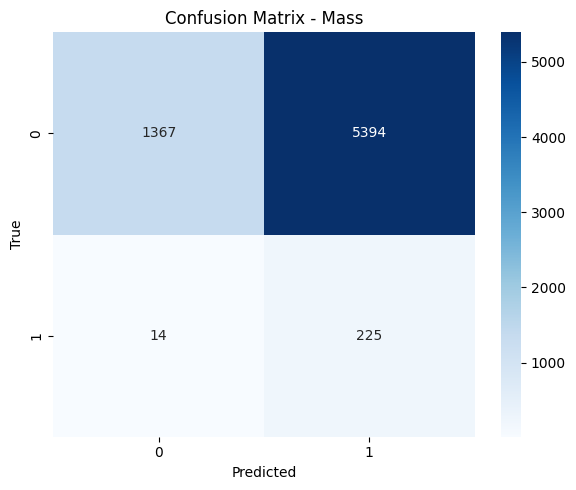

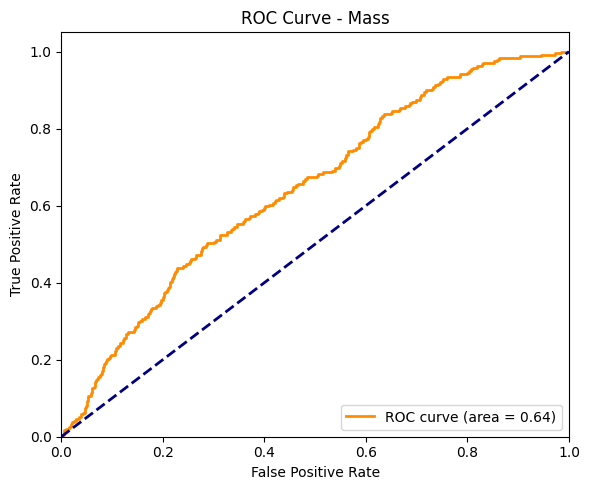

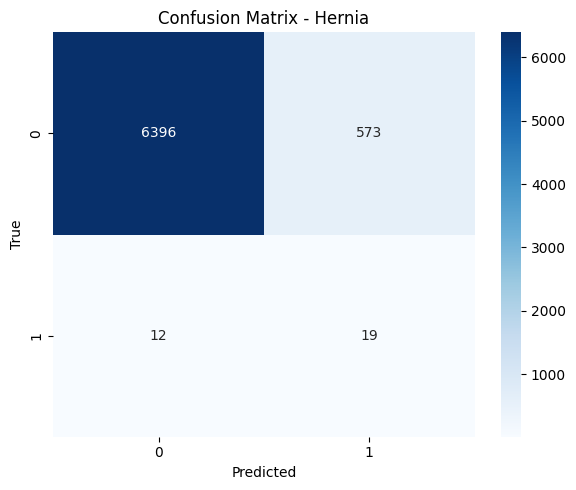

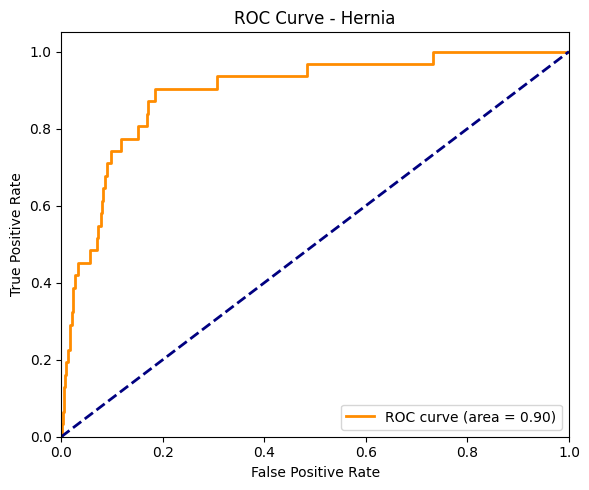

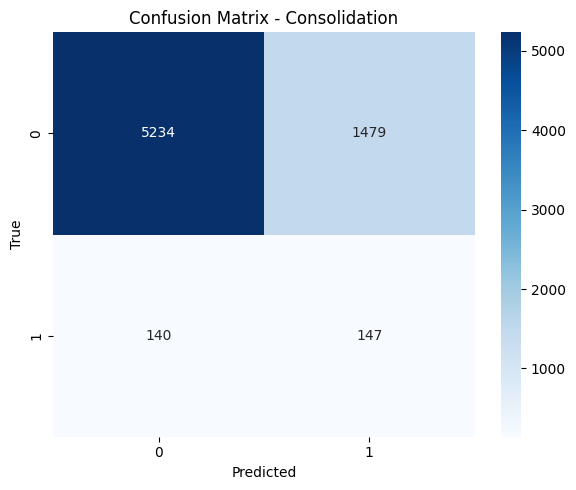

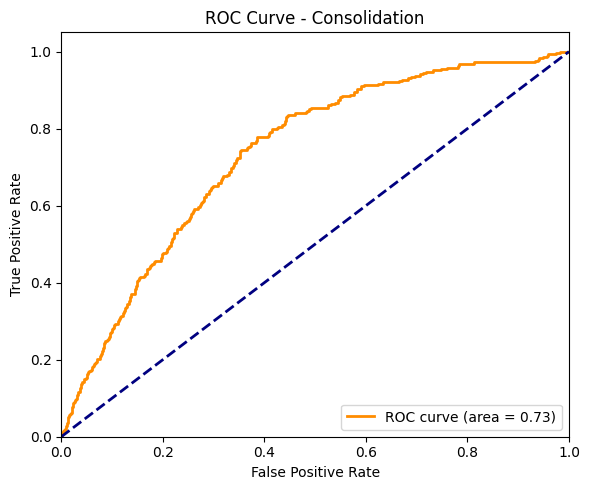

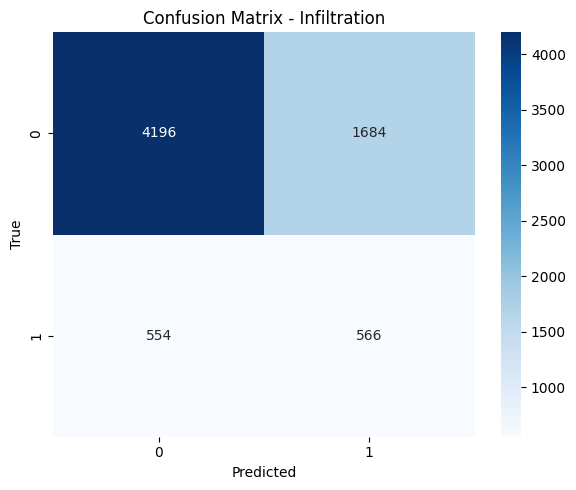

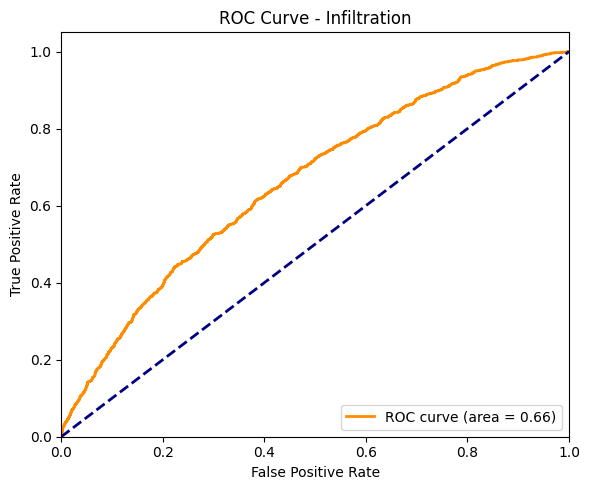

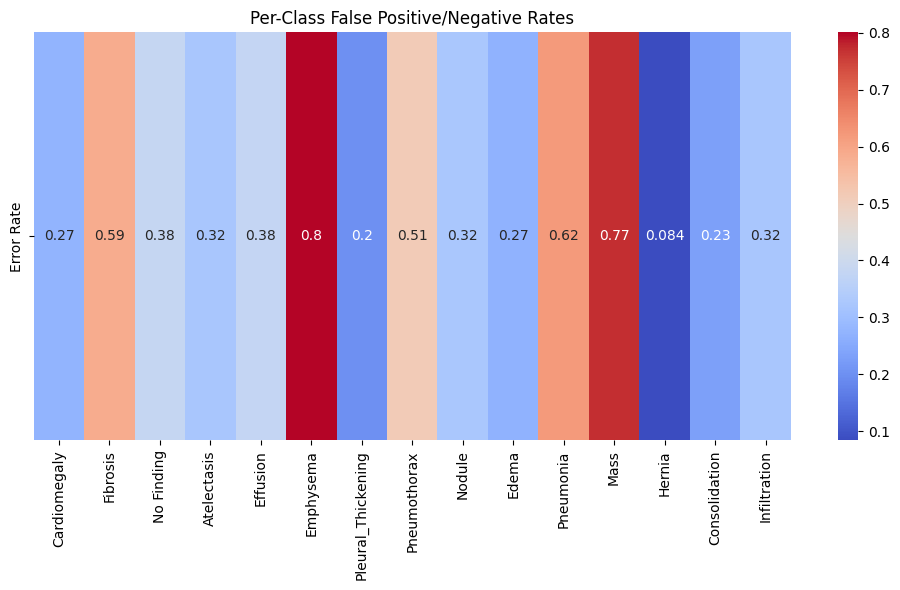

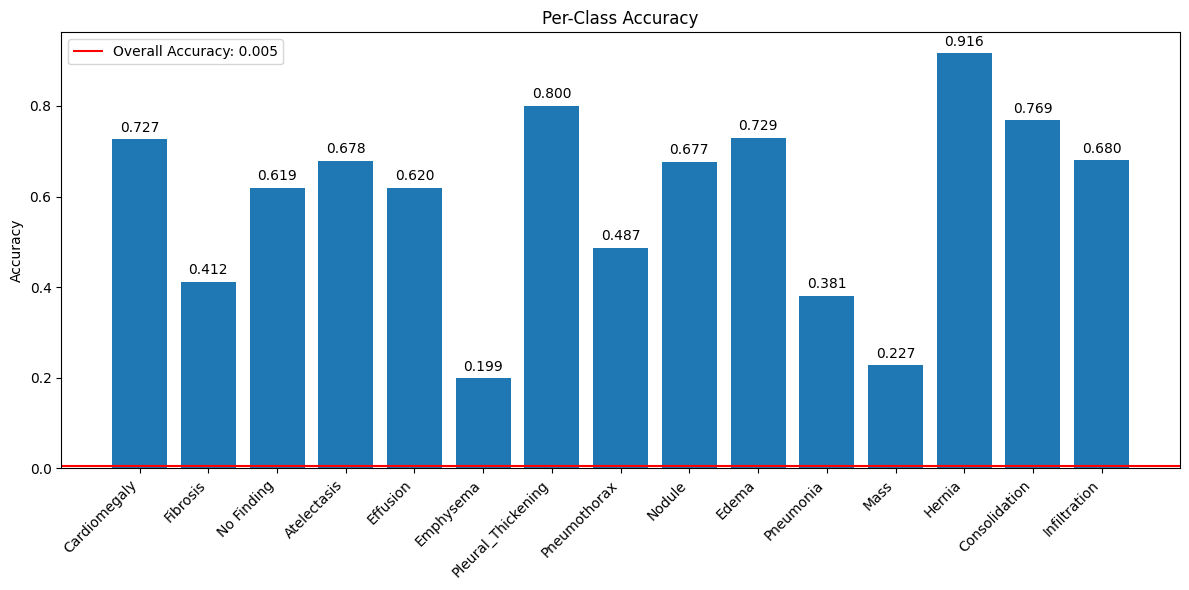

======= Evaluation Results =======
Accuracy: 0.0047
F1 Score: 0.2310
Precision: 0.1460
Recall: 0.6747
Jaccard Similarity: 0.1439
Average Confidence: 0.4610
Samples Evaluated: 7000
Evaluation Time: 38.67 seconds


In [7]:

metrics = me.evaluate_multi_model(model, data_loader, device, class_names=data_loader.dataset.get_labels())
# me.visualize_predictions(model, data_loader, device, num_examples=5, class_names=dataset_xrays_test.classes)
# misclass_df = me.analyze_misclassifications(model, data_loader, device, class_names=dataset_xrays_train.classes)
# hard_examples = me.find_hard_examples(model, data_loader, device, n=5)

Eval against test set

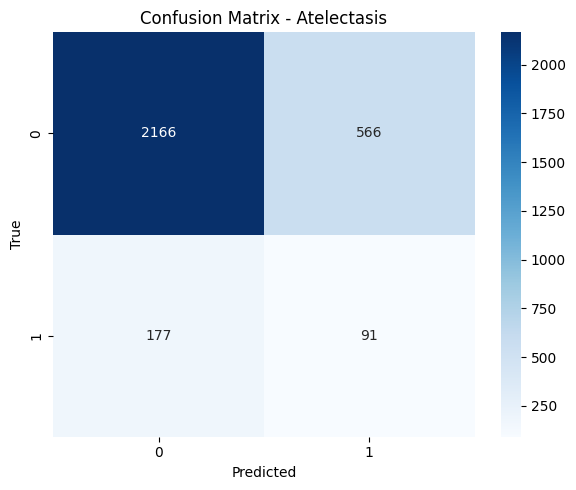

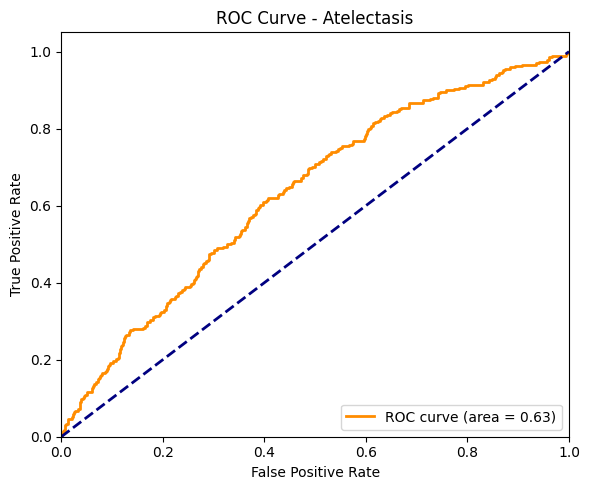

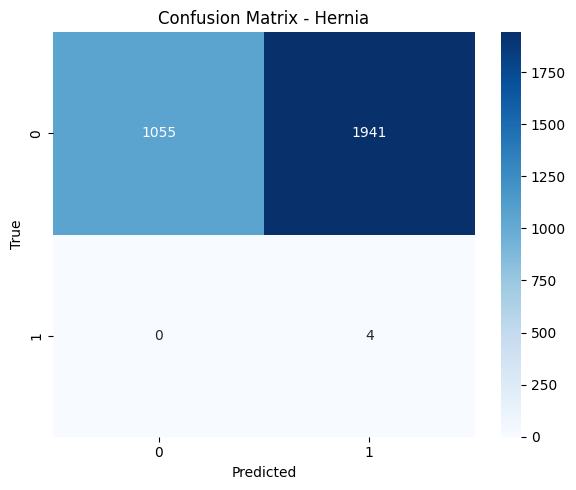

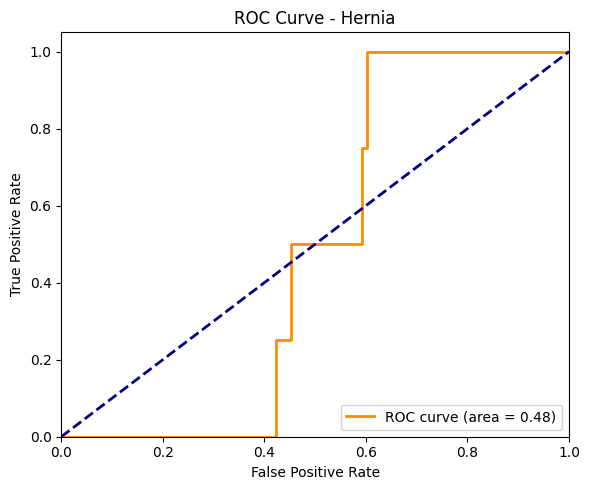

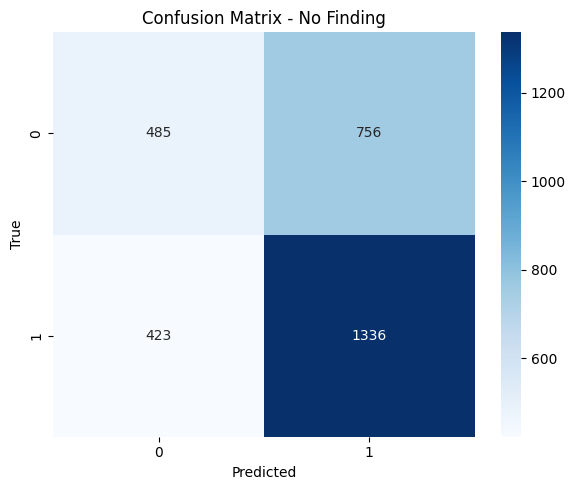

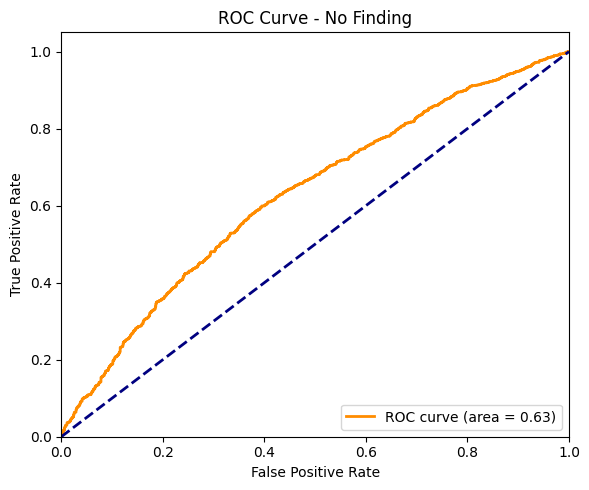

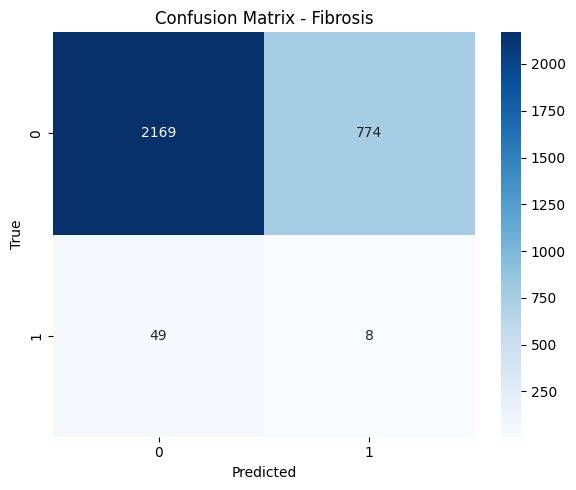

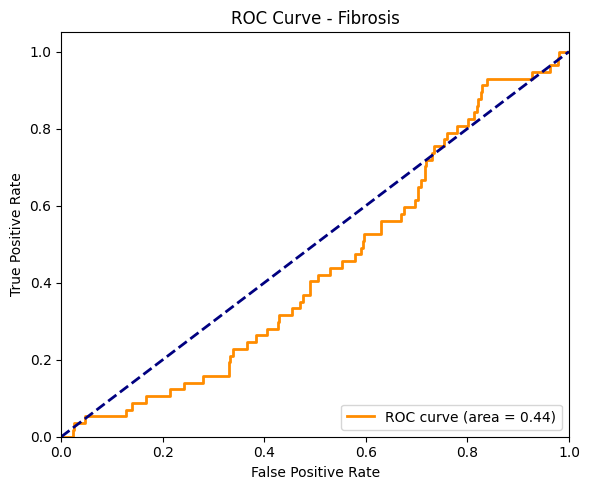

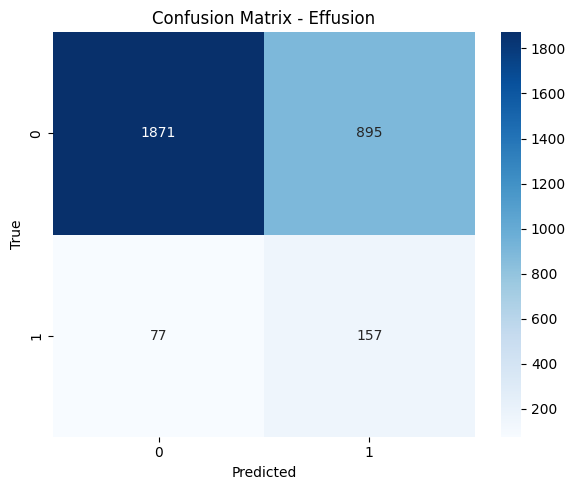

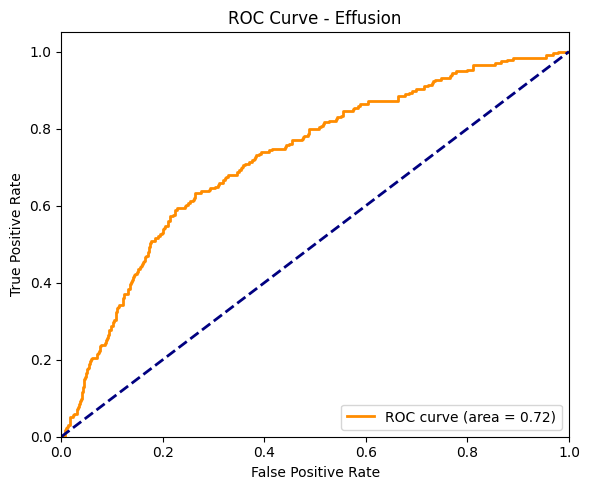

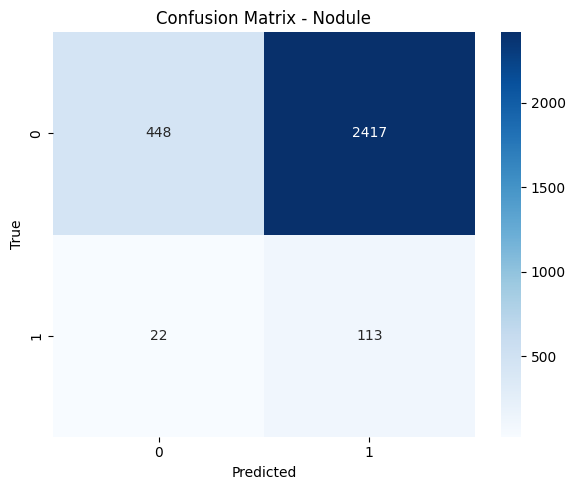

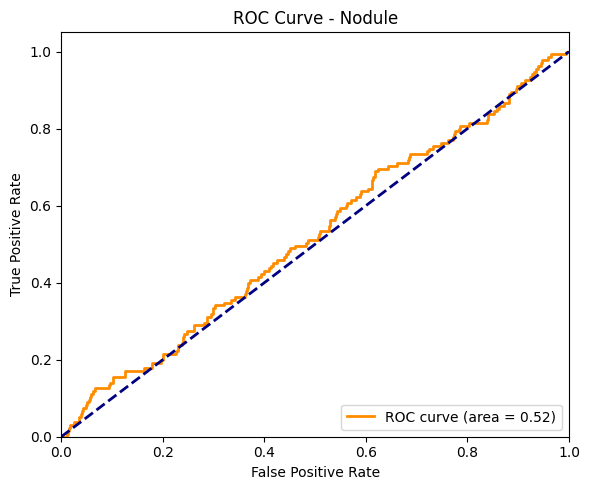

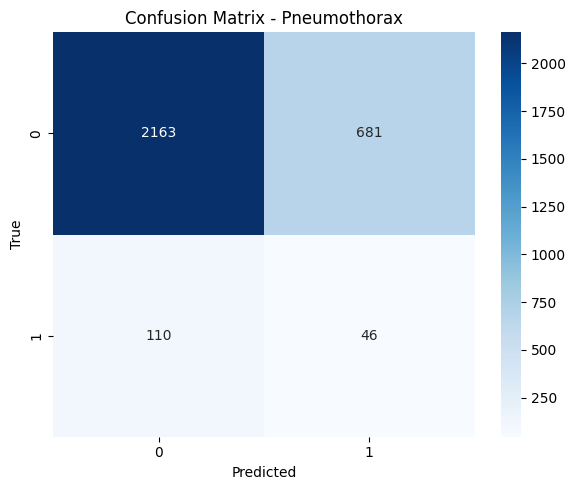

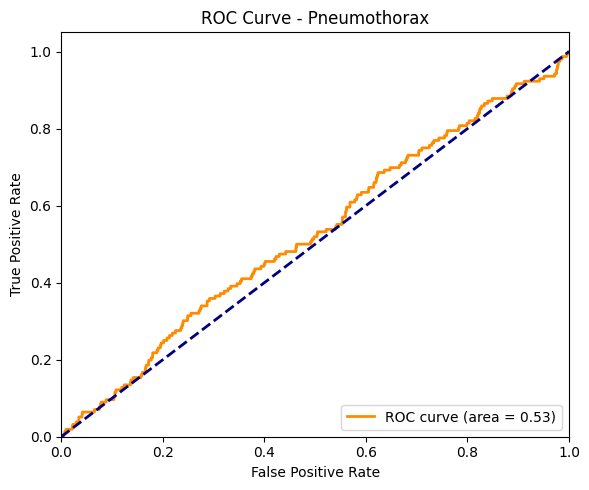

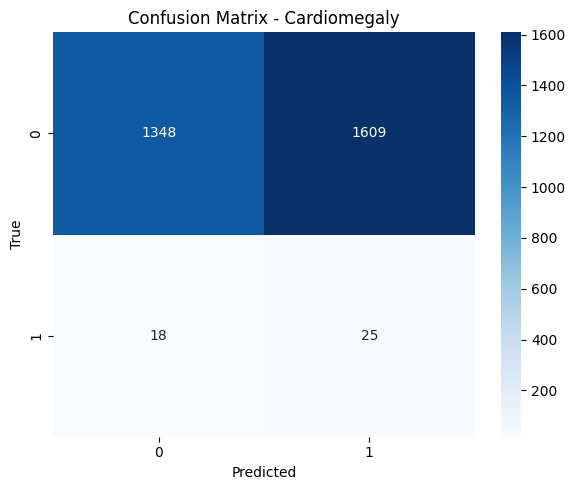

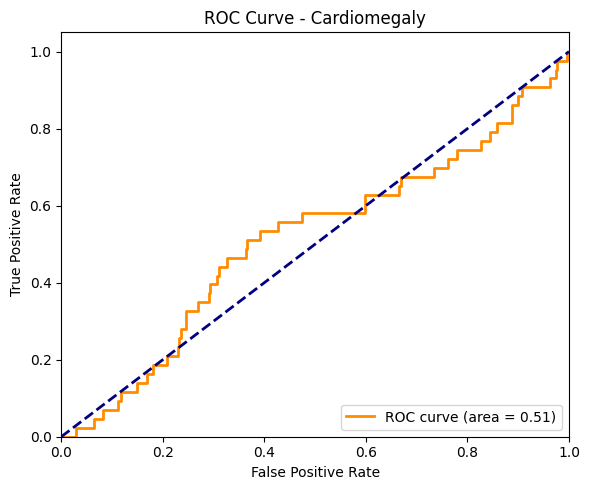

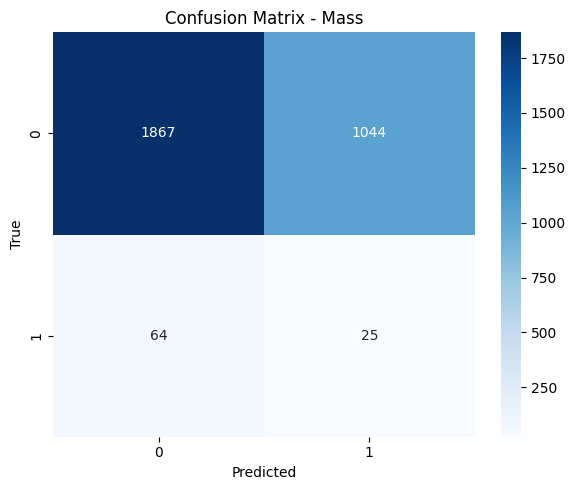

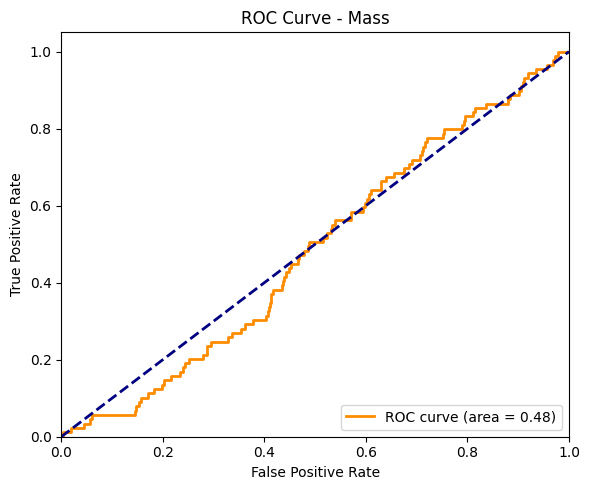

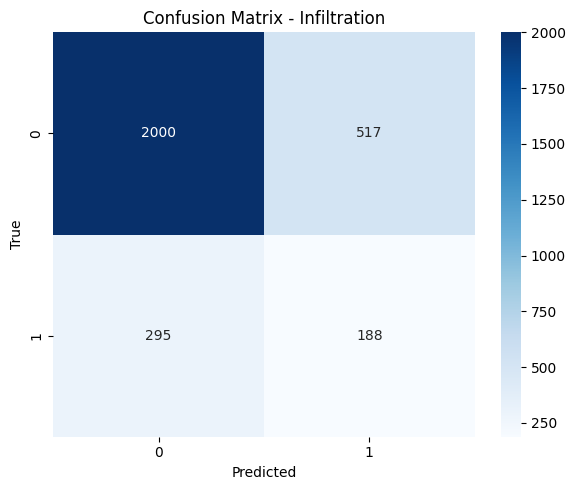

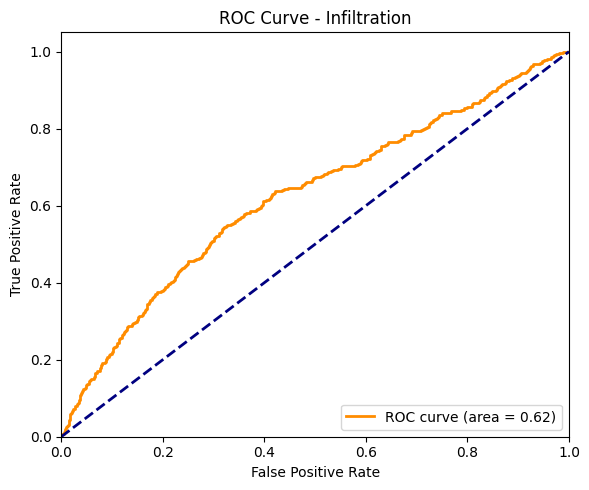

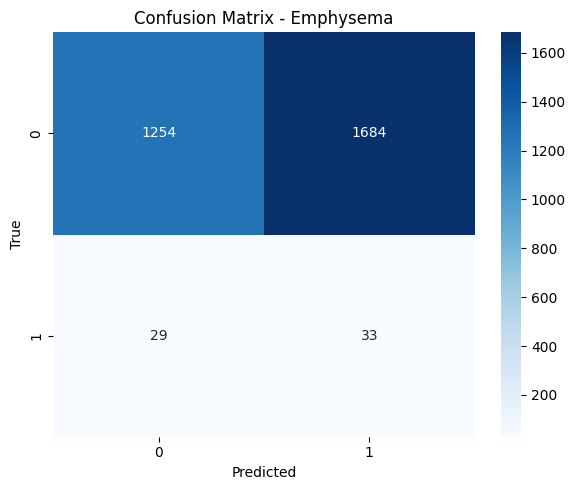

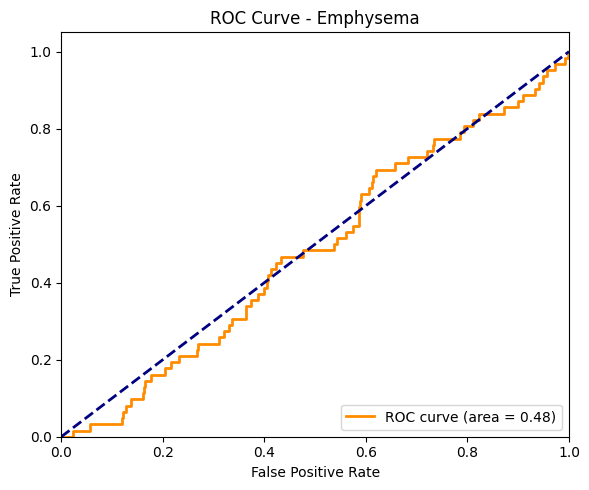

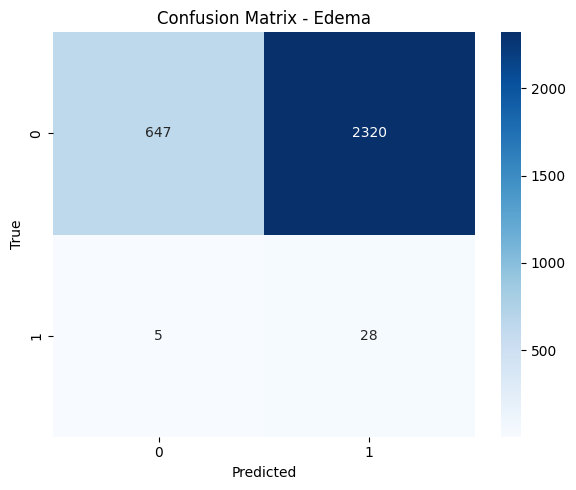

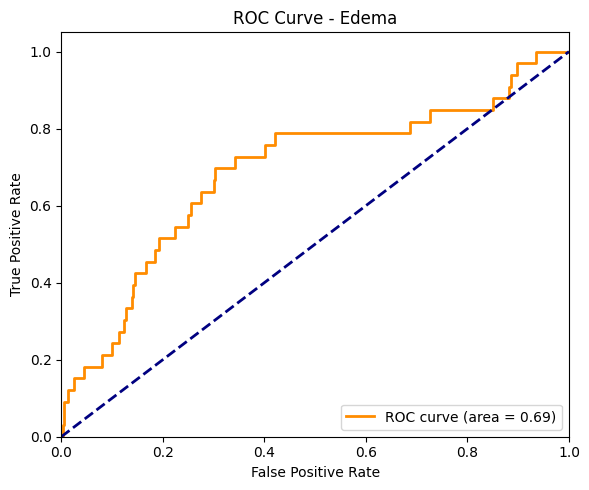

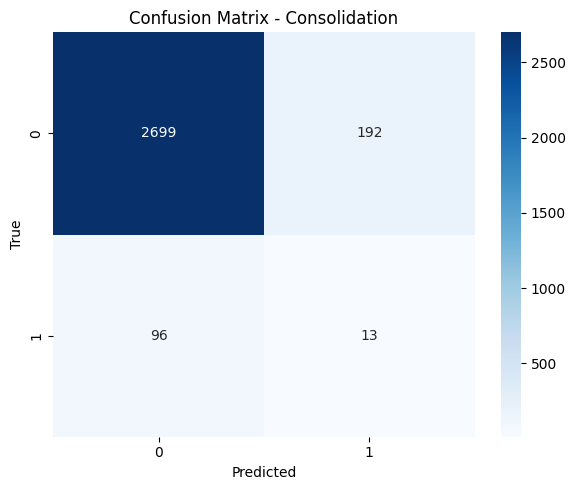

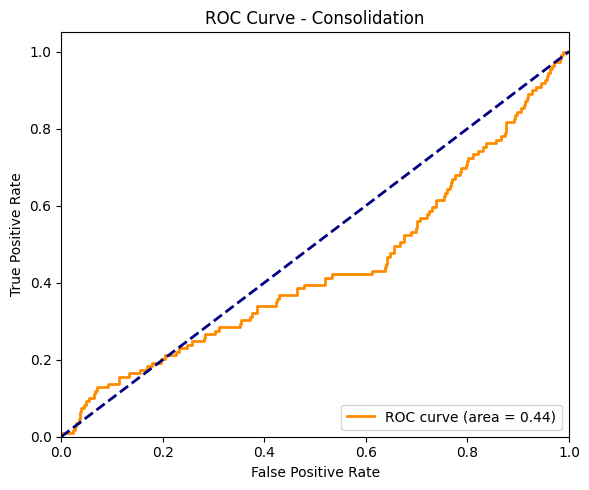

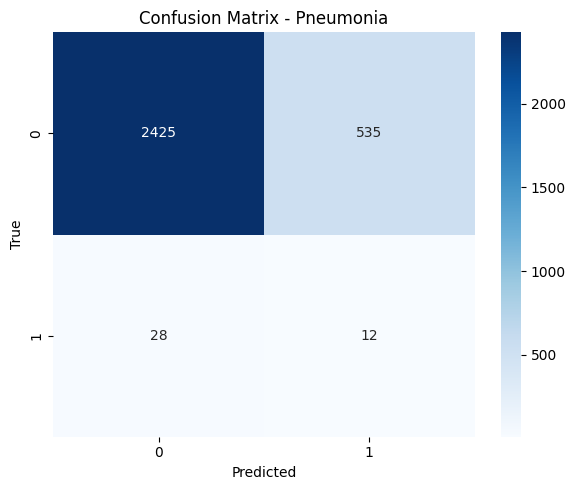

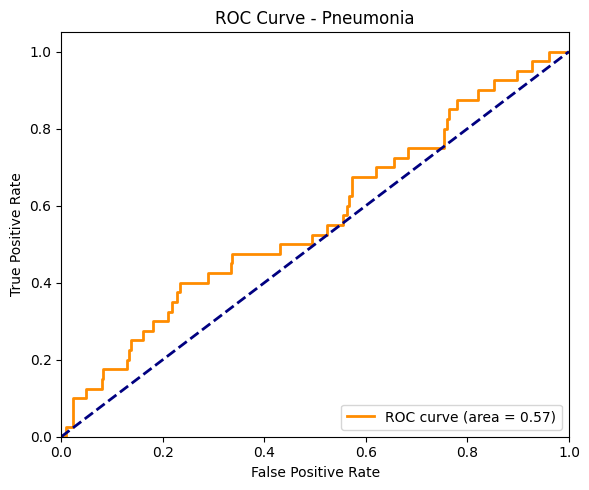

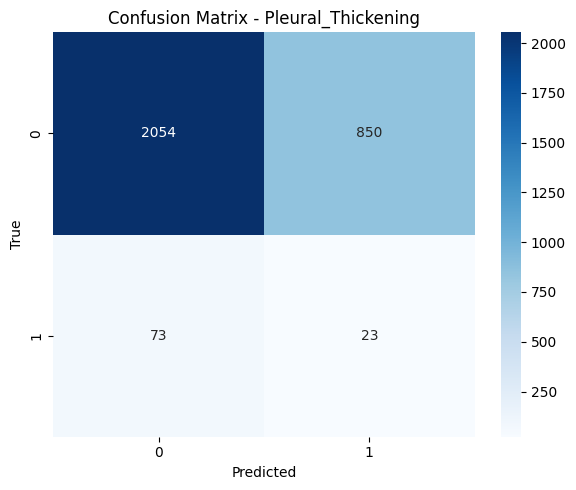

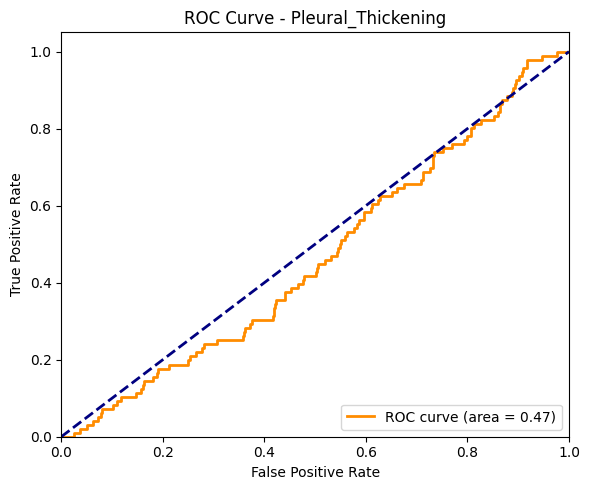

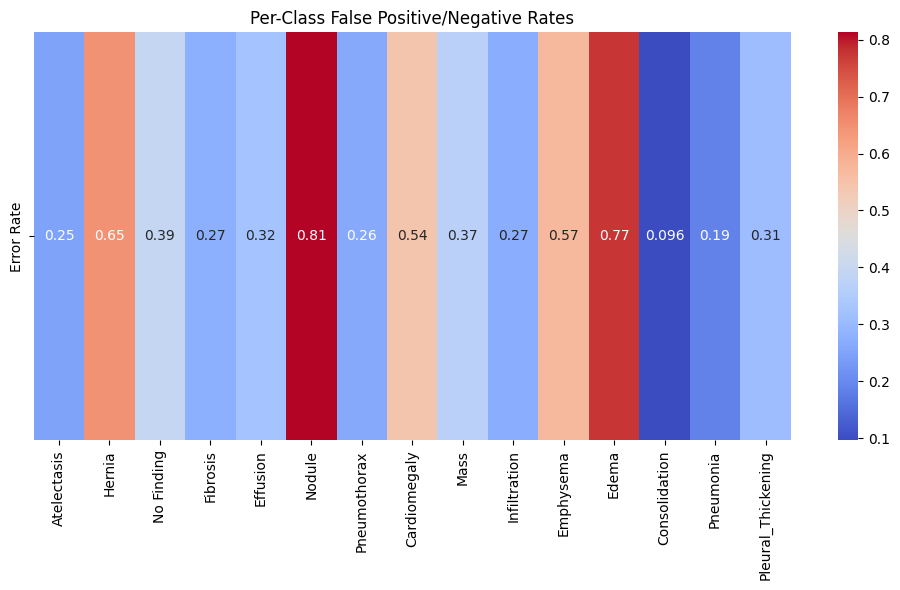

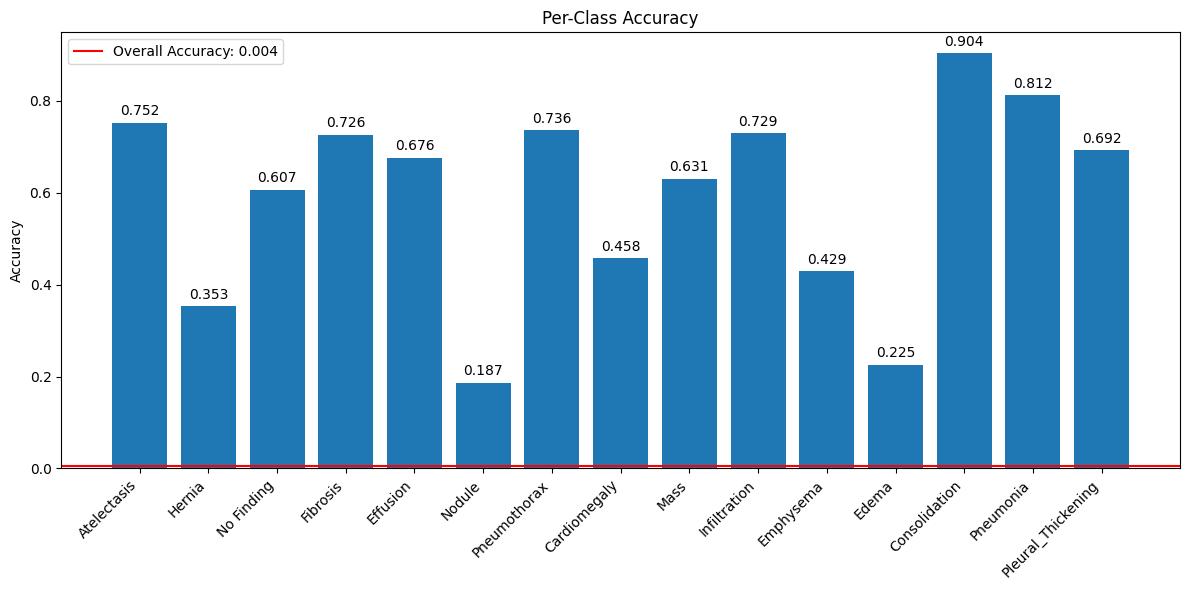

======= Evaluation Results =======
Accuracy: 0.0043
F1 Score: 0.2089
Precision: 0.1315
Recall: 0.6163
Jaccard Similarity: 0.1296
Average Confidence: 0.4536
Samples Evaluated: 3000
Evaluation Time: 17.30 seconds


In [8]:

metrics = me.evaluate_multi_model(model, data_loader_test, device, class_names=data_loader_test.dataset.get_labels())
# me.visualize_predictions(model, data_loader_test, device, num_examples=5, class_names=dataset_xrays_test.classes)
# misclass_df = me.analyze_misclassifications(model, data_loader_test, device, class_names=dataset_xrays_test.classes)
# hard_examples = me.find_hard_examples(model, data_loader_test, device, n=5)